In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import infomap
from matplotlib import pyplot as plt
from matplotlib import colors
import statsmodels.api as sm
from tqdm.autonotebook import tqdm
from matplotlib.lines import Line2D
import string

<ipython-input-1-9878c18abf21>:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Text(0.5, 1.0, '$\\bf{Figure~1.}$ Communities inferred from board interlocks.')

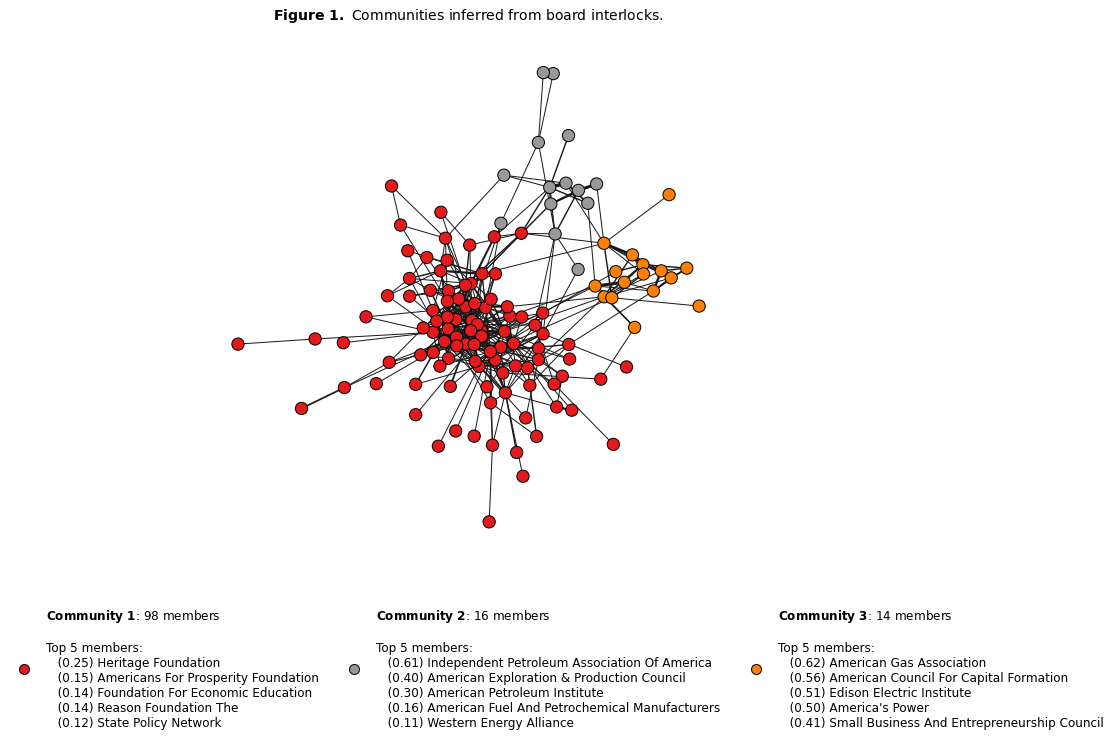

In [78]:
df_org = pd.read_csv('data/metadata.csv')

df_intr = pd.read_json('data/cccm_interlocks.json')
df_intr = df_intr[df_intr.Verified]

df_ofc = pd.read_csv('data/officers.csv')

eins = pd.read_csv('data/eins.csv')
ein_to_name = eins.set_index('EIN').ORG
name_to_ein = eins.set_index('ORG').EIN

edgelist = pd.DataFrame(
    [
        {
            'ein1': row.ein1,
            'ein2': row.ein2,
            'strength': 1
        }
        for idx, row in df_intr.iterrows()
        if not ((row.ein1 == row.ein2))
    ]
).groupby(['ein1', 'ein2',]).strength.sum().reset_index(drop = False)

edgelist = edgelist[edgelist.strength > 0]

edgelist.columns = ['source', 'target', 'weight']
edgelist['source'] = edgelist.source.map(ein_to_name)
edgelist['target'] = edgelist.target.map(ein_to_name)

edgelist = edgelist[~edgelist.apply(lambda r: 'MECHANICAL' in str(r), 1)]

G_interlocks = nx.from_pandas_edgelist(edgelist, edge_attr = 'weight')

G_interlocks = G_interlocks.subgraph(next(nx.connected_components(G_interlocks)))

for e in G_interlocks.edges(data = True):
    G_interlocks.edges[e[:2]]['distance'] = 1/e[2]['weight']
    
V = list(G_interlocks.nodes)

im = infomap.Infomap()
im.add_networkx_graph(G_interlocks, weight='weight')
im.run()
interlock_communities = pd.Series({V[k]:v for k,v in im.get_modules().items()})
nx.set_node_attributes(G_interlocks, interlock_communities, 'community')

communities_list = [c for c in nx.get_node_attributes(G_interlocks, 'community').values()]
num_communities = max(communities_list) + 1

# color map from http://colorbrewer2.org/
cmap = "Set1"#colors.ListedColormap(
   # ['#d53e4f','#fc8d59','#fee08b','#e6f598','#99d594','#3288bd'], 'indexed', num_communities)

pos = nx.spring_layout(G_interlocks, k = 1, iterations = 5000, seed = 19012022)
ew = [e[2]['weight']**0.5 for e in G_interlocks.edges(data = True)] 

fig, ax = plt.subplots(1,1, figsize = (10,10))

nodes = nx.draw_networkx_nodes(G_interlocks, ax = ax, pos = pos, node_color = communities_list, node_size = 150, cmap = cmap)
nodes.set_edgecolor('k')
edges = nx.draw_networkx_edges(G_interlocks, ax = ax, pos = pos, width = ew, edge_color = (0.1,0.1,0.1,1))

legend_markers = [
    Line2D(
        [0],                          
        [0],                          
        mfc=nodes.cmap(nodes.norm(m)),                          
        markersize = 100**0.5,                          
        lw = 0,                          
        marker = 'o',                          
        mec = 'k'
    )  
    for m in interlock_communities.unique()
]

top_members = {}

for m in sorted(interlock_communities.unique()):
    t_m = interlock_communities[interlock_communities == m]
    G_m = G_interlocks.subgraph(t_m.index.values)
    centrality = pd.Series(dict(nx.betweenness_centrality(G_m, weight = 'distance')))
    
    top_members[m] = (
        (interlock_communities == m).sum(),
        '\n   '.join(["(%.2f) "%n + string.capwords(idx) for idx, n in centrality.sort_values()[:-6:-1].iteritems()])
    )

legend_titles = [r"$\bf{Community~" + str(m)+r"}$:" + f" {N} members\n\nTop 5 members:\n   {members}" for m, (N, members) in top_members.items()]
ax.invert_xaxis()
ax.legend(legend_markers, legend_titles, ncol = 3, loc='upper center', bbox_to_anchor=(0.66, -0.05), frameon = False, fontsize = 12)

# Add the title and remove the plot edges
[ax.spines[s].set_visible(False) for s in ax.spines]

ax.set_title(r"$\bf{Figure~1.}$ Communities inferred from board interlocks.", fontsize = 14)

<ipython-input-93-faacad042dc1>:85: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  for label, a in topicprops[topicprops.org.map(topic_communities) == m].mean().reindex(retainedtopics).sort_values()[:-11:-1].iteritems()])


Text(0.5, 1.0, '$\\bf{Figure~2.}$ Communities inferred from topic proportions.')

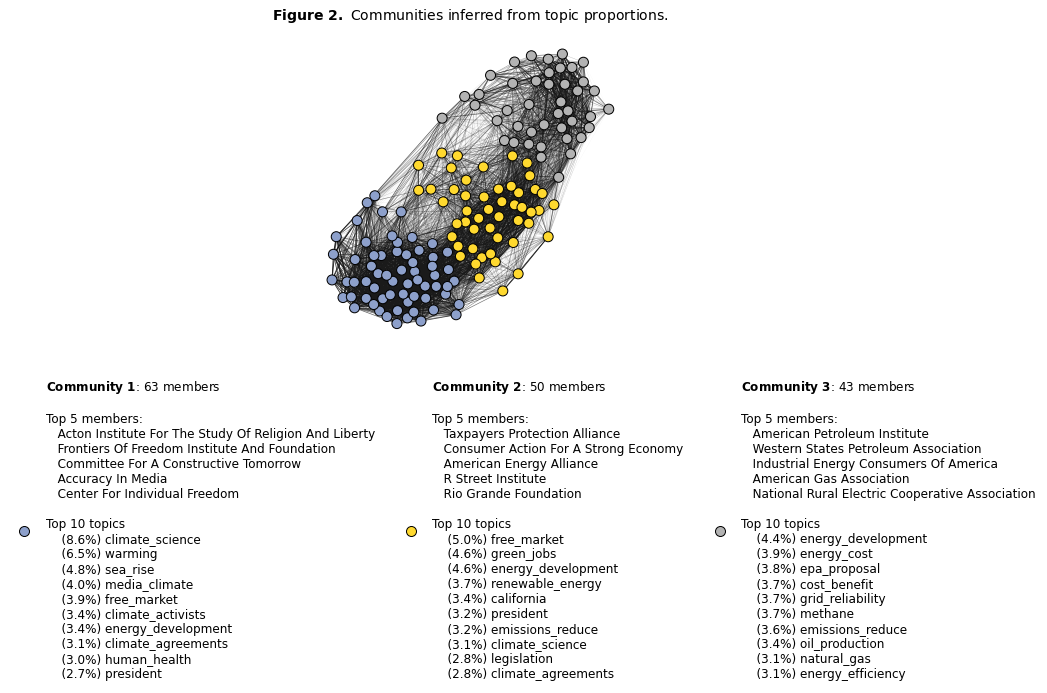

In [93]:
topics = ['V%i'%i for i in range(1, 51)]

topicprops = pd.read_csv('stm/topicproportions.csv').drop('Unnamed: 0', axis = 1, errors = 'ignore')
docs = pd.read_csv('stm/document_sample.csv').drop(['Unnamed: 0', 'text'], axis = 1, errors = 'ignore')
topiclabels = pd.read_csv('stm/topiclabels.csv').drop('Unnamed: 0', axis = 1)

topiclabels['topic'] = topics
retainedtopics = topiclabels[~topiclabels.remove].topic.values

topicprops['org'] = docs.org
topicprops['year'] = docs.year
topicprops['org_community'] = topicprops.org.map(interlock_communities)
topicprops = topicprops.drop(topiclabels[topiclabels.remove].topic, axis = 1)

org_community_topics = topicprops[['org_community', *retainedtopics]].groupby(['org_community'])[retainedtopics].mean().loc[[1,2,3],:].T
org_community_topics['label'] = org_community_topics.index.map(topiclabels.set_index('topic').label)

p = - np.log(topicprops[retainedtopics])
centered = ((p - p.mean())/p.std()).join(topicprops.org)

org_topics = centered.groupby(['org'])[retainedtopics].sum().T

def cossim(a, b):
    return (a * b).sum() / (sum(a**2) * sum(b**2))**0.5

A_topics = org_topics.corr(method = cossim)
np.fill_diagonal(A_topics.values, 0)
A_topics[A_topics < 0] = 0
A_topics = A_topics.replace(np.nan, 0)

G_topics = nx.Graph(A_topics)

for e in G_topics.edges(data = True):
    G_topics.edges[e[:2]]['distance'] = 1/e[2]['weight']

V = list(G_topics.nodes)

im = infomap.Infomap(markov_time = 1)
im.add_networkx_graph(G_topics, weight='weight')
im.run()
topic_communities = pd.Series({V[k]:v for k,v in im.get_modules().items()})
nx.set_node_attributes(G_topics, topic_communities, 'community')

# G_org_topics.add_nodes_from(eins.ORG.values)

topic_communities_list = [G_topics.nodes(data=True)[n].get('community') for n in G_topics]

cmap = 'Set2'

pos = nx.spring_layout(G_topics, k = 0.1, weight = 'weight', iterations = 1000, seed = 19012022)

ew = [e[2]['weight'] for e in G_topics.edges(data = True)] 

fig, ax = plt.subplots(1,1, figsize = (6,6))

nodes = nx.draw_networkx_nodes(G_topics, ax = ax, pos = pos, node_color = topic_communities_list, node_size = 100, cmap = cmap, vmin = 0)
nodes.set_edgecolor('k')
edges = nx.draw_networkx_edges(G_topics, ax = ax, pos = pos, width = ew, edge_color = [(0.1,0.1,0.1,w) for w in ew])

legend_markers = [
    Line2D(
        [0],                          
        [0],                          
        mfc=nodes.cmap(nodes.norm(m)),                          
        markersize = 100**0.5,                          
        lw = 0,                          
        marker = 'o',                          
        mec = 'k'
    )  
    for m in topic_communities.unique()
]

top_members = {}

for m in sorted(topic_communities.unique()):
    t_m = topic_communities[topic_communities == m]
    G_m = G_topics.subgraph(t_m.index.values)
    centrality = pd.Series(dict(nx.closeness_centrality(G_m, distance = 'distance')))
    
    top_members[m] = (
    (
        topic_communities == m).sum(),
        '\n   '.join([string.capwords(idx) for idx in centrality.sort_values()[:-6:-1].index.values]),
        '\n   '.join([f" (%.1f%%) "%(a * 100) + topiclabels.set_index('topic').label[label] 
                      for label, a in topicprops[topicprops.org.map(topic_communities) == m].mean().reindex(retainedtopics).sort_values()[:-11:-1].iteritems()])
    )

legend_titles = [r"$\bf{Community~" + str(m)+r"}$:" + f" {N} members\n\nTop 5 members:\n   {members}\n\nTop 10 topics\n   {topics}" for m, (N, members, topics) in top_members.items()]
ax.invert_xaxis()
ax.legend(legend_markers, legend_titles, ncol = 3, loc='upper center', bbox_to_anchor=(0.66, -0.05), frameon = False, fontsize = 12)

# Add the title and remove the plot edges
[ax.spines[s].set_visible(False) for s in ax.spines]

ax.set_title(r"$\bf{Figure~2.}$ Communities inferred from topic proportions.", fontsize = 14)

# Overlaps between communities

In [94]:
combined = pd.DataFrame([interlock_communities, topic_communities]).T.dropna()
combined.columns = ['interlock_group', 'topic_group',]
combined.value_counts().unstack()

topic_group,1.0,2.0,3.0
interlock_group,,,
1.0,47.0,37.0,8.0
2.0,NaN,1.0,13.0
3.0,2.0,2.0,9.0


In [95]:
combined[(combined.interlock_group == 1) & (combined.topic_group == 3)]

,interlock_group,topic_group
FREE TO CHOOSE NETWORK,1.0,3.0
NATIONAL ASSOCIATION OF MANUFACTURERS,1.0,3.0
REASON FOUNDATION THE,1.0,3.0
MERCATUS CENTER GEORGE MASON UNIVERSITY,1.0,3.0
INSTITUTE FOR ENERGY RESEARCH,1.0,3.0
THOMAS JEFFERSON INSTITUTE FOR PUBLIC POLICY,1.0,3.0
BEACON HILL INSTITUTE FOR PUBLIC POLICY RESEARCH,1.0,3.0
BUCKEYE INSTITUTE FOR PUBLIC POLICY SOLUTIONS THE,1.0,3.0


# Edge correlations between topics and interlocks

In [34]:
data = []
G_interlocks_inv = G_interlocks.copy()
for edge in G_interlocks_inv.edges:
    G_interlocks_inv.edges[edge]['weight'] **= -1

V = list(G_interlocks_inv.nodes)
    
for i in range(len(G_interlocks_inv)):
    for j in range(i + 1, len(G_interlocks_inv)):
        d = nx.shortest_path_length(G_interlocks_inv, V[i], V[j], weight = 'weight')
        data.append([V[i], V[j], d])
        data.append([V[j], V[i], d])

In [64]:
A_topics = org_topics.corr(method = cossim)
np.fill_diagonal(A_topics.values, 0)

# A_interlocks = nx.adjacency_matrix(G_interlocks).toarray()
# A_interlocks = pd.DataFrame(A_interlocks, columns = G_interlocks.nodes, index = G_interlocks.nodes)

A_interlocks = 1/pd.DataFrame(data).set_index([0,1]).unstack()
A_interlocks.columns = A_interlocks.columns.droplevel()

overlap = {*A_topics.index} & {*A_interlocks.index}

y = A_topics.reindex(index=overlap, columns=overlap)
y = y.where(np.tril(np.ones(y.shape)).astype(bool)).stack()

x = A_interlocks.reindex(index=overlap, columns=overlap)
x = x.where(np.tril(np.ones(x.shape)).astype(bool)).stack().sort_values()

y = y.reindex(x.index)

def bootstrap_lowess(x, y, N):
    
    l = len(x)
    assert l == len(y)
        
    idx = np.arange(l)
                    
    samples = [np.random.choice(idx, l, replace = True) for n in range(N)]
    
    return np.array([sm.nonparametric.lowess(y[i], x[i], xvals = np.arange(max(x) + 1)) for i in tqdm(samples)])
    
plotvals = bootstrap_lowess(x.values, y.values, 1000)


  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, '$\\bf{Figure~3.}$ Interlocks predict topic similarity between groups.\n')

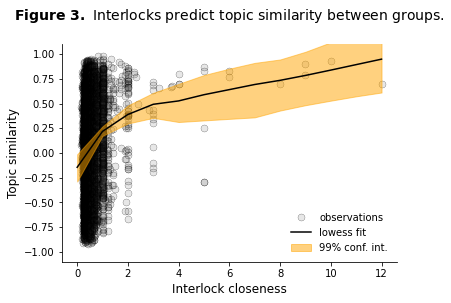

In [116]:
plt.figure(figsize = (6, 4))

plt.plot(x, y, lw = 0, ms = 7, marker = 'o', mec = 'k', zorder = -1, mfc = (0.1,0.1,0.1,0.1), markeredgewidth = 0.2, label = 'observations')

plt.plot(np.arange(max(x)+ 1), plotvals.mean(0), color = 'k', label = 'lowess fit')

for conf in [0.01]:
    plt.fill_between(np.arange(max(x)+ 1),  *np.quantile(plotvals.T, [conf/2, 1 - (conf/2)], axis = 1), color = 'orange', alpha = 0.5, label = '99% conf. int.')
    
ax = plt.gca()
ax.legend(frameon = False)
ax.set_ylim(-1.1, 1.1)
[ax.spines[s].set_visible(False) for s in ('top', 'right')]
ax.set_xlabel('Interlock closeness', fontsize = 12)
ax.set_ylabel('Topic similarity', fontsize = 12)
ax.set_title(r"$\bf{Figure~3.}$ Interlocks predict topic similarity between groups."+"\n", fontsize = 14)

In [84]:
y.sort_values()

0                                                         1                                   
AMERICAN SPECTATOR FOUNDATION                             WESTERN ENERGY ALLIANCE                -0.924529
WESTERN ENERGY ALLIANCE                                   NATIONAL REVIEW INSTITUTE              -0.908150
                                                          ADVOCATES FOR SELF GOVERNMENT          -0.907206
CENTER FOR THE STUDY OF CARBON DIOXIDE AND GLOBAL CHANGE  RIO GRANDE FOUNDATION                  -0.905963
FRONTIERS OF FREEDOM INSTITUTE AND FOUNDATION             WESTERN STATES PETROLEUM ASSOCIATION   -0.899991
                                                                                                    ...   
LIBERTY FUND                                              FREE THE PEOPLE                         0.949451
CENTER FOR THE STUDY OF CARBON DIOXIDE AND GLOBAL CHANGE  CO2 COALITION                           0.950761
ATLAS SOCIETY                                    